In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import cv2
import matplotlib.pyplot as plt

import timm
from glob import glob
import os
from tqdm import tqdm

# **Configuration** 설정

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/aiConnect_2nd

Mounted at /content/drive
/content/drive/MyDrive/aiConnect_2nd


In [4]:
# ! unzip /content/drive/MyDrive/yeardream_2nd/train.zip -d /content/drive/MyDrive/yeardream_2nd
# ! unzip /content/drive/MyDrive/yeardream_2nd/test.zip -d /content/drive/MyDrive/yeardream_2nd

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


cfg = dotdict(
    device ='cuda', #'cuda' #cpu
    batch_size = 8,
    epochs = 16,
    lr = 1e-2,)

In [6]:
# 데이터셋 경로 설정
data_dir = '/content/drive/MyDrive/aiConnect_2nd/data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [7]:
!pwd

/content/drive/MyDrive/aiConnect_2nd


# **EDA** 기본분석

In [8]:
# 데이터 수량 체크
train_defect_images = glob(train_dir + '/defect_images/*.png')
train_normal_images = glob(train_dir + '/normal_images/*.png')

print(f'total number of train dataset : {len(train_defect_images) + len(train_normal_images)}')
print(f'defect : {len(train_defect_images)}')
print(f'normal : {len(train_normal_images)}')

total number of train dataset : 6820
defect : 30
normal : 6790


Text(0.5, 1.0, 'Distribution of train dataset')

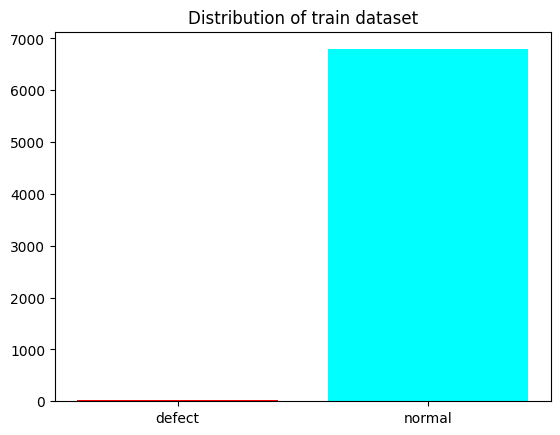

In [9]:
# 클래스 분포 체크
plt.bar(['defect', 'normal'], [len(train_defect_images), len(train_normal_images)], color=['red', 'cyan'])
plt.title('Distribution of train dataset')

# **Train Valid Data Split** 데이터 분할

In [10]:
total_dataset = train_defect_images + train_normal_images
label = [1] * len(train_defect_images) + [0] * len(train_normal_images)

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(train_defect_images+train_normal_images,
                                                  label,
                                                  test_size=0.3,
                                                  random_state=42,
                                                  stratify=label)

print(f'train dataset : {len(X_train)}, val dataset : {len(X_val)}')
print(f'train label : {len(y_train)}, val label : {len(y_val)}')

train dataset : 4774, val dataset : 2046
train label : 4774, val label : 2046


# **CustomDataset** 클래스 정의

In [11]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [12]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_val, y_val)

train_loader = DataLoader(train_dataset,
                          batch_size=cfg.batch_size,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=cfg.batch_size,
                         shuffle=False,
                         num_workers=2,
                         pin_memory=True)

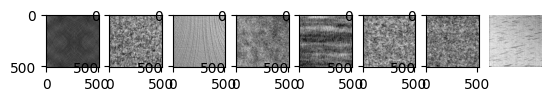

In [13]:
# 데이터 샘플 체크
for batch in train_loader:
    imgs, labels = batch
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 총 사진의 개수만큼 plot

    for i, img in enumerate(imgs):
        plt.axis('off')
        axs[0, i].imshow(img.squeeze(), cmap='gray')
    break

# CNN Model 정의 (resnet18d)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder =  timm.create_model('resnet18d', pretrained=True, in_chans=1)
        # self.encoder =  timm.create_model('resnet34d', pretrained=True, in_chans=1)

        self.head = nn.Linear(1000, 1)

    def forward(self, image, mode='train'):
        x = self.encoder(image)
        output = self.head(x)
        output = torch.sigmoid(output)
        return output

# 모델, Loss, Optimizer 선언

In [15]:
model = Net()

model = model.to(cfg.device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.9M [00:00<?, ?B/s]

# 학습 모델 저장 경로 설정

In [16]:
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

# 학습 및 검증

In [17]:
# Train and Valid Loop

metric_best = 0.
model_file = os.path.join(model_dir, f'best.pt')

for epoch in range(cfg.epochs):
    # Train Loop
    train_loss = 0
    train_outputs = []
    train_labels = []
    for batch in tqdm(train_loader, desc=f'train-{epoch}'):
        imgs, labels = batch

        imgs = imgs.to(cfg.device).float()
        labels = labels.to(cfg.device)

        optimizer.zero_grad()

        output = model(imgs.unsqueeze(1))
        loss = criterion(output, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_outputs.append(output.cpu().detach())
        train_labels.append(labels.cpu().detach())

    train_loss /= len(train_loader)

    # Validation Loop
    val_loss = 0
    val_outputs = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'val-{epoch}'):
            imgs, labels = batch

            imgs = imgs.to(cfg.device).float()
            labels = labels.to(cfg.device)

            output = model(imgs.unsqueeze(1))
            loss = criterion(output, labels.unsqueeze(1).float())

            val_loss += loss.item()
            val_outputs.append(output.cpu().detach())
            val_labels.append(labels.cpu().detach())

    val_loss /= len(test_loader)
    train_outputs = (torch.cat(train_outputs) > 0.5).float().squeeze(-1)
    val_outputs = (torch.cat(val_outputs) > 0.5).float().squeeze(-1)
    train_labels = torch.cat(train_labels)
    val_labels = torch.cat(val_labels)

    train_acc = accuracy_score(train_labels, train_outputs)
    val_acc = accuracy_score(val_labels, val_outputs)

    train_f1 = f1_score(train_labels, train_outputs, average='macro')
    val_f1 = f1_score(val_labels, val_outputs, average='macro')

    if val_f1 > metric_best:
        print(f'metric_best ({metric_best:.6f} --> {val_f1:.6f}). Saving model ...')
        torch.save(model.state_dict(), model_file)
        metric_best = val_f1

    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}, Train F1: {train_f1}, Val F1: {val_f1}')


val-0: 100%|██████████| 256/256 [08:48<00:00,  2.07s/it]


metric_best (0.000000 --> 0.498898). Saving model ...
Epoch: 0, Train Loss: 0.17779851569677366, Val Loss: 0.2829399754318729, Train Acc: 0.9935064935064936, Val Acc: 0.9956011730205279, Train F1: 0.49837133550488605, Val F1: 0.49889786921381335


val-1: 100%|██████████| 256/256 [00:22<00:00, 11.34it/s]


Epoch: 1, Train Loss: 0.16829594557847444, Val Loss: 0.17077170233869765, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-2: 100%|██████████| 256/256 [00:22<00:00, 11.52it/s]


Epoch: 2, Train Loss: 0.1642667259356643, Val Loss: 0.23202460568749927, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-3: 100%|██████████| 256/256 [00:22<00:00, 11.24it/s]


Epoch: 3, Train Loss: 0.1390872748357567, Val Loss: 0.23766000393131037, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-4: 100%|██████████| 256/256 [00:22<00:00, 11.55it/s]


Epoch: 4, Train Loss: 0.10754868236006075, Val Loss: 0.07524106412654419, Train Acc: 0.9953917050691244, Val Acc: 0.9956011730205279, Train F1: 0.49884526558891457, Val F1: 0.49889786921381335


val-5: 100%|██████████| 256/256 [00:22<00:00, 11.46it/s]


Epoch: 5, Train Loss: 0.11750505943600681, Val Loss: 0.16393567078245042, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-6: 100%|██████████| 256/256 [00:24<00:00, 10.58it/s]


Epoch: 6, Train Loss: 0.14598186339097743, Val Loss: 0.17163801017886726, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-7: 100%|██████████| 256/256 [00:21<00:00, 11.80it/s]


Epoch: 7, Train Loss: 0.09779678059206481, Val Loss: 0.07309173475186981, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-8: 100%|██████████| 256/256 [00:24<00:00, 10.59it/s]


Epoch: 8, Train Loss: 0.12933539281734685, Val Loss: 0.07646761440571481, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-9: 100%|██████████| 256/256 [00:22<00:00, 11.17it/s]


Epoch: 9, Train Loss: 0.13042686611589155, Val Loss: 0.16020925035457703, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-10: 100%|██████████| 256/256 [00:23<00:00, 11.10it/s]


Epoch: 10, Train Loss: 0.3363130033006648, Val Loss: 0.36374033987522125, Train Acc: 0.9941348973607038, Val Acc: 0.9956011730205279, Train F1: 0.4985294117647059, Val F1: 0.49889786921381335


val-11: 100%|██████████| 256/256 [00:24<00:00, 10.54it/s]


Epoch: 11, Train Loss: 0.36796356645261424, Val Loss: 0.36374033987522125, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-12: 100%|██████████| 256/256 [00:22<00:00, 11.19it/s]


Epoch: 12, Train Loss: 0.3691124820229995, Val Loss: 0.36374033987522125, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-13: 100%|██████████| 256/256 [00:21<00:00, 11.76it/s]


Epoch: 13, Train Loss: 0.3619781283277962, Val Loss: 0.36374033987522125, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-14: 100%|██████████| 256/256 [00:24<00:00, 10.41it/s]


Epoch: 14, Train Loss: 0.37434194954595773, Val Loss: 0.36374033987522125, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


val-15: 100%|██████████| 256/256 [00:25<00:00, 10.14it/s]

Epoch: 15, Train Loss: 0.37611933728957697, Val Loss: 0.36374033242464066, Train Acc: 0.9956011730205279, Val Acc: 0.9956011730205279, Train F1: 0.49889786921381335, Val F1: 0.49889786921381335


# Pytorch CustomTestDataset 클래스 정의

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image / 255.0

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [ ]:
test_images = glob(test_dir + '/images/*.png')

print(f'the number of test images : {len(test_images)}')

In [ ]:
test_dataset = CustomTestDataset(test_images)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 학습된 모델 로드

In [ ]:
model_dir = './models'
model_file = os.path.join(model_dir, f'best.pt')

model = Net()
model.load_state_dict(torch.load(model_file))
model = model.to(cfg.device)

# 추론 수행

In [ ]:
image_names = []
test_outputs = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        imgs, image_name = batch
        imgs = imgs.to(cfg.device).float()

        output = model(imgs.unsqueeze(1))
        test_outputs.append(output.cpu().detach())
        image_names.extend(image_name)

test_outputs = (torch.cat(test_outputs) > 0.5).int().squeeze(-1)

100%|██████████| 256/256 [00:17<00:00, 14.81it/s]


# 추론 결과 저장

In [ ]:
submission = pd.DataFrame({'ImageId': image_names, 'answer': test_outputs.tolist()})
submission = submission.sort_values(by=['ImageId']).reset_index(drop=True)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,ImageId,answer
0,tensor(0),0
1,tensor(0),0
2,tensor(0),0
3,tensor(0),0
4,tensor(0),0
...,...,...
2041,tensor(1),1
2042,tensor(1),0
2043,tensor(1),0
2044,tensor(1),0


In [ ]:
submission['answer'].value_counts()

0    2042
1       4
Name: answer, dtype: int64